In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle 

In [2]:
# Obtain CelebA faces dataset
!mkdir celeba
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba/data.zip

Downloading...
From: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
To: /content/celeba/data.zip
100% 1.44G/1.44G [00:08<00:00, 174MB/s]


In [3]:
# Unzip 
!unzip -qq celeba/data.zip -d celeba

In [4]:
# batch size for image batches
batch_size = 32

# Extract images as 64x64 to dataset
dataset_images = keras.preprocessing.image_dataset_from_directory('celeba', batch_size=batch_size,
                                                           label_mode=None, image_size=(64, 64))

Found 202599 files belonging to 1 classes.


In [5]:
# normalize pixel values
dataset_images = dataset_images.map(lambda x: x / 255.)

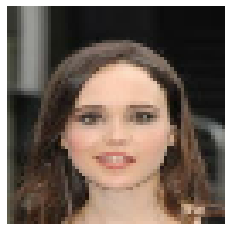

In [ ]:
# Display a celebrity face
import matplotlib.pyplot as plt
for x in dataset_images:
  plt.axis("off")
  plt.imshow((x.numpy() * 255).astype('int32')[0])
  break

In [6]:
# Discriminator architecture (per Radford et al.)

# The discriminator takes a 64x64 RGB image and classifies it to a binary value (0=fake or 1=real)
# It is a relatively simple classifier, but will be trained using two separate loss functions (in discriminator and generator training)
discriminator = keras.Sequential(
    [
        # Input layer for 64x64 RGB image
        keras.Input(shape=(64, 64, 3)),
     
        # First convolutional layer w/ activation
        keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        keras.layers.LeakyReLU(alpha=0.2),

        # Second convolutional layer w/ activation
        keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        keras.layers.LeakyReLU(alpha=0.2),
     
       # Third convolutional layer w/ activation
        keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        keras.layers.LeakyReLU(alpha=0.2),

        # Flatten layer for mapping to output
        keras.layers.Flatten(),
     
        # Dropout layer to prevent overfitting
        keras.layers.Dropout(0.2),
     
        # Dense layer w/ sigmoid to map to output
        keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="Discriminator",
)
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [7]:
# Generator architecture (per Radford et al.)

# The generator creates fake images to feed into the discriminator
# The goal is to trick the discriminator into thinking the generated image is real
# At first, the generator is given random noise; it gets better by iteratively computing loss from the discriminator and backpropagating

noiseDim = 100 # dimension of uniform distribution vector Z
latent_dim = 100

generator = keras.Sequential(
    [
        # Start with vector Z
        keras.layers.Input(shape=(noiseDim,)),
        
        # Project and reshape to 4x4x1024
        keras.layers.Dense(4*4*1024, input_shape = [noiseDim]),
        keras.layers.Reshape([4, 4, 1024]),
        
        # First fractionally-strided convolutional layer (Transpose Convolution) with leaky ReLU activation 
        keras.layers.Conv2DTranspose(512, kernel_size = 4, padding = "same", strides = 2),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
  
        # Second convolutional layer
        keras.layers.Conv2DTranspose(256, kernel_size = 4, padding = "same", strides = 2),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.BatchNormalization(),
        
        # Third convolutional layer
        keras.layers.Conv2DTranspose(128, kernel_size = 4, padding = "same", strides = 2),
        keras.layers.LeakyReLU(alpha=0.2),
           
        # Final layer outputting a 64x64x3 image 
        keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                  activation='tanh'),
    ],
    name="Generator",
)

generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        8389120   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      20

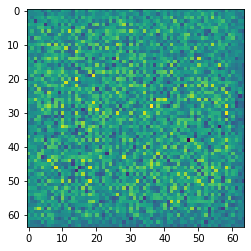

In [ ]:
# Testing image generation out of random noise
noise_shape = 100

noise = tf.random.normal([1,noise_shape])
image = generator(noise, training=False)
plt.imshow(image[0, :, :, 0])

In [ ]:
# for ease of compilation and overriding, we define GAN as a class, inheriting keras.Model
class GAN(keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
    
    # encode all the necessary compilation information
    def compile(self):
        super(GAN, self).compile()
        self.discriminatorOpt = keras.optimizers.Adam(learning_rate=0.0001) 
        self.generatorOpt = keras.optimizers.Adam(learning_rate=0.0001) 
        self.loss = keras.losses.BinaryCrossentropy()
        self.d_loss_metric = keras.metrics.Mean(name="discriminatorLoss")
        self.g_loss_metric = keras.metrics.Mean(name="generatorLoss")

    # The metrics to keep track of discriminator and generator loss
    @property
    def metrics(self):
      return [self.d_loss_metric, self.g_loss_metric]
       
    # override keras' default train_step function since we're training 2 models at once   
    def train_step(self, images):
        ## Discriminator Training

        # Get random points from latent noise z-distribution 
        batch_size = tf.shape(images)[0]
        noise = tf.random.normal(shape=(batch_size, noise_shape))

        # Turn this into fake images using the generator
        generated_images = self.generator(noise)

        # Combine real images with fake images
        combined_images = tf.concat([generated_images, images], axis=0)

        # Concatenate real and fake labels
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Add noise to labels to make training more robust
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            # get discriminator predictions on real vs fake
            discriminatorPredictions = self.discriminator(combined_images)
            # calculate loss on discriminator
            discriminatorLoss = self.loss(labels, discriminatorPredictions)

        # get gradients and update discriminator weights
        gradients = tape.gradient(discriminatorLoss, self.discriminator.trainable_weights)
        self.discriminatorOpt.apply_gradients(zip(gradients, self.discriminator.trainable_weights))

        ## Generator Training

        # Get noise again from normal distribution
        noise = tf.random.normal(shape=(batch_size, noise_shape))

        # Creating np array of all-zeros to 
        real = tf.zeros((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            # get discriminator predictions for newly generated fake images
            discriminatorPredictions = self.discriminator(self.generator(noise))
            # get the generator's loss (not discriminator) given discriminator's predictions
            generatorLoss = self.loss(real, discriminatorPredictions)

        # get gradients of generator loss
        gradients = tape.gradient(generatorLoss, self.generator.trainable_weights)
        # update generator weights, but keep discriminator's weights the same 
        self.generatorOpt.apply_gradients(zip(gradients, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(discriminatorLoss)
        self.g_loss_metric.update_state(generatorLoss)
        return {
            "discriminatorLoss": self.d_loss_metric.result(),
            "generatorLoss": self.g_loss_metric.result(),
        }


from google.colab import drive
drive.mount('/content/gdrive')

# callback function to save images and data 
class customCallback(keras.callbacks.Callback):
  def __init__(self, images):
    self.images = images

  # override on_epoch_end to display images after each epoch is done training
  def on_epoch_end(self, epoch, logs=None):
    noise = tf.random.normal(shape=(self.images, noise_shape))
    # get fake generated images
    fake = self.model.generator(noise)
    fake *= 255
    fake.numpy()
    for i in range(self.images):
      # create images and print them
      image = keras.preprocessing.image.array_to_img(fake[i])
      image.save("/content/gdrive/My Drive/images_DCGAN_final2/generated_img_%03d_%d.png" % (epoch+1, i))
      plt.subplot(2, 5, i+1)
      plt.imshow(fake[i].numpy().astype('uint8'))
      plt.xticks([])  
      plt.yticks([]) 
    plt.tight_layout()
    plt.show()


Mounted at /content/gdrive


Epoch 1/30
6332/6332 [==============================] - ETA: 0s - discriminatorLoss: 0.6205 - generatorLoss: 1.1785

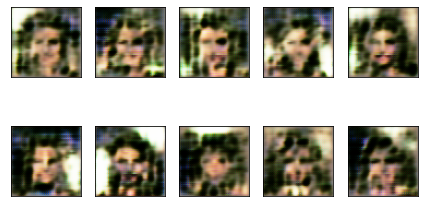

6332/6332 [==============================] - 903s 142ms/step - discriminatorLoss: 0.6205 - generatorLoss: 1.1785
Epoch 2/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6510 - generatorLoss: 1.0737

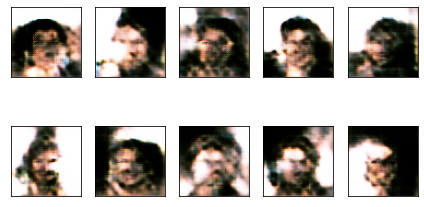

6332/6332 [==============================] - 899s 142ms/step - discriminatorLoss: 0.6510 - generatorLoss: 1.0736
Epoch 3/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6570 - generatorLoss: 1.0326

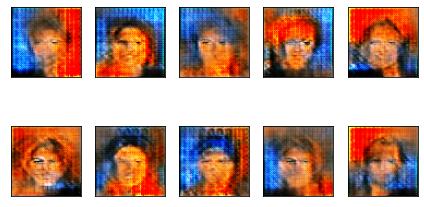

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6570 - generatorLoss: 1.0326
Epoch 4/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6414 - generatorLoss: 1.0868

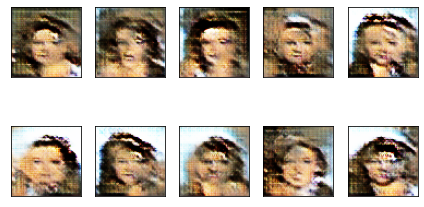

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6414 - generatorLoss: 1.0868
Epoch 5/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6218 - generatorLoss: 1.0945

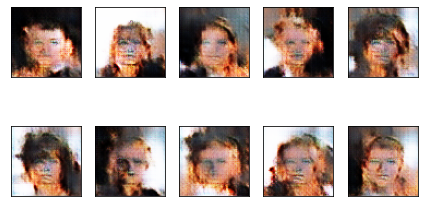

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6218 - generatorLoss: 1.0945
Epoch 6/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6539 - generatorLoss: 0.9940

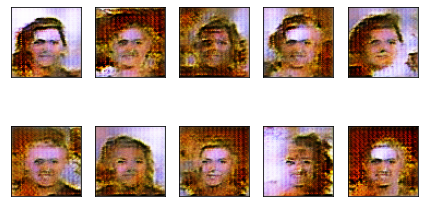

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6539 - generatorLoss: 0.9939
Epoch 7/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6625 - generatorLoss: 0.9605

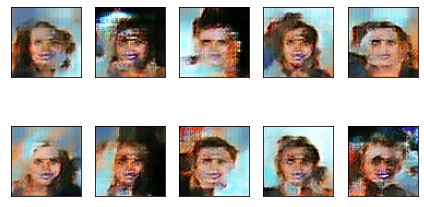

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6625 - generatorLoss: 0.9604
Epoch 8/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6625 - generatorLoss: 0.9533

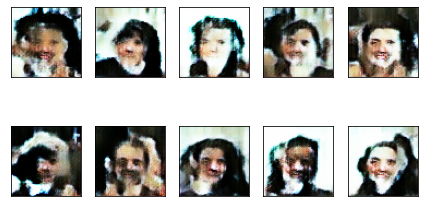

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6625 - generatorLoss: 0.9533
Epoch 9/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6637 - generatorLoss: 0.9400

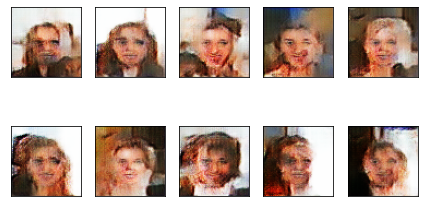

6332/6332 [==============================] - 896s 142ms/step - discriminatorLoss: 0.6637 - generatorLoss: 0.9400
Epoch 10/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6662 - generatorLoss: 0.9157

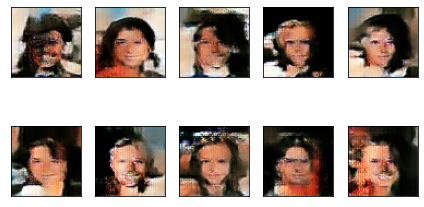

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6662 - generatorLoss: 0.9156
Epoch 11/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6728 - generatorLoss: 0.9221

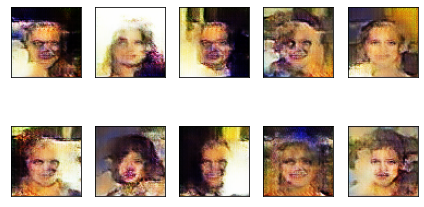

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6728 - generatorLoss: 0.9221
Epoch 12/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6671 - generatorLoss: 0.9272

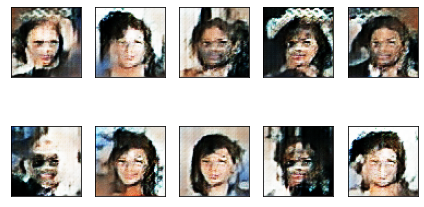

6332/6332 [==============================] - 896s 141ms/step - discriminatorLoss: 0.6671 - generatorLoss: 0.9272
Epoch 13/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6631 - generatorLoss: 0.9277

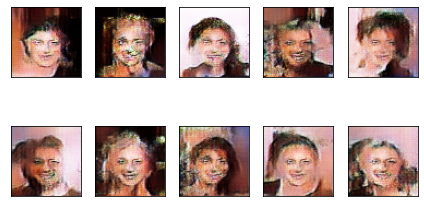

6332/6332 [==============================] - 896s 142ms/step - discriminatorLoss: 0.6631 - generatorLoss: 0.9277
Epoch 14/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6629 - generatorLoss: 0.9286

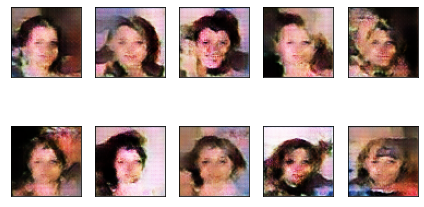

6332/6332 [==============================] - 896s 142ms/step - discriminatorLoss: 0.6630 - generatorLoss: 0.9286
Epoch 15/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6519 - generatorLoss: 0.9356

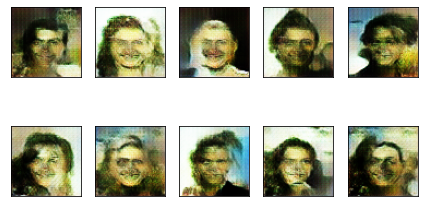

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6519 - generatorLoss: 0.9356
Epoch 16/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6617 - generatorLoss: 0.9271

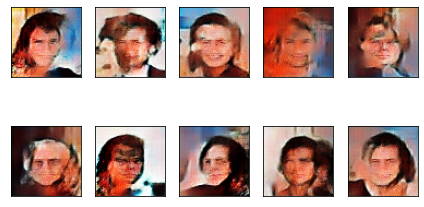

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6617 - generatorLoss: 0.9271
Epoch 17/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6569 - generatorLoss: 0.9338

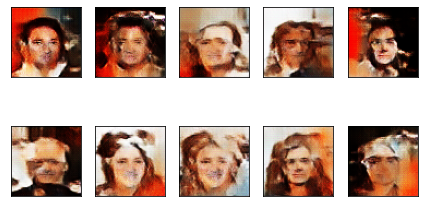

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6569 - generatorLoss: 0.9338
Epoch 18/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6588 - generatorLoss: 0.9367

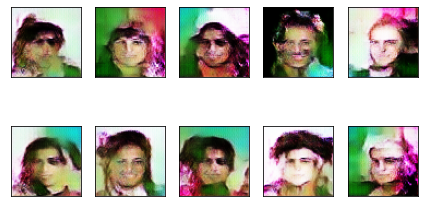

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6589 - generatorLoss: 0.9367
Epoch 19/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6576 - generatorLoss: 0.9329

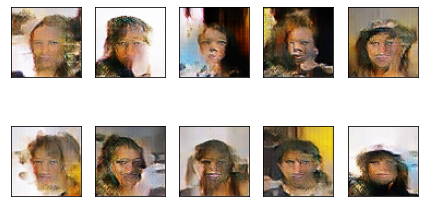

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6576 - generatorLoss: 0.9329
Epoch 20/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6515 - generatorLoss: 0.9464

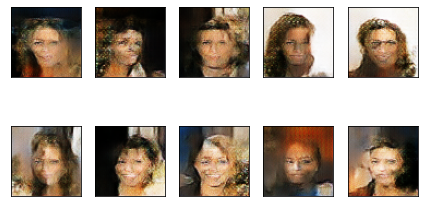

6332/6332 [==============================] - 896s 142ms/step - discriminatorLoss: 0.6515 - generatorLoss: 0.9464
Epoch 21/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6592 - generatorLoss: 0.9284

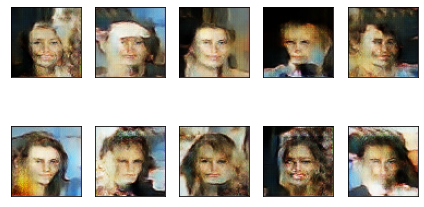

6332/6332 [==============================] - 896s 142ms/step - discriminatorLoss: 0.6592 - generatorLoss: 0.9284
Epoch 22/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6532 - generatorLoss: 0.9441

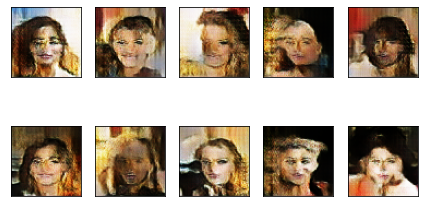

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6532 - generatorLoss: 0.9441
Epoch 23/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6579 - generatorLoss: 0.9215

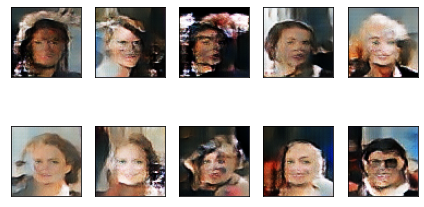

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6579 - generatorLoss: 0.9215
Epoch 24/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6532 - generatorLoss: 0.9305

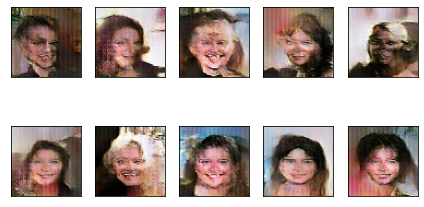

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6532 - generatorLoss: 0.9305
Epoch 25/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6524 - generatorLoss: 0.9364

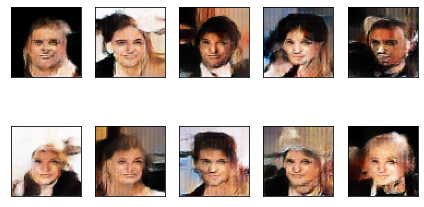

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6524 - generatorLoss: 0.9364
Epoch 26/30
6332/6332 [==============================] - ETA: 0s - discriminatorLoss: 0.6507 - generatorLoss: 0.9343

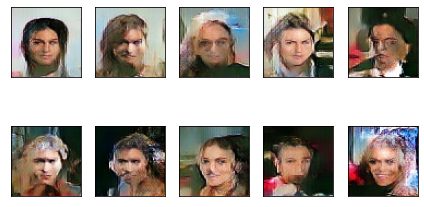

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6507 - generatorLoss: 0.9343
Epoch 27/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6549 - generatorLoss: 0.9298

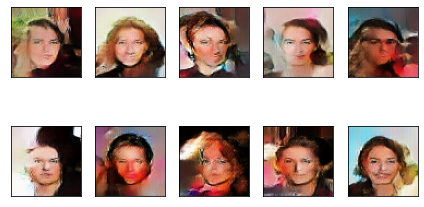

6332/6332 [==============================] - 897s 142ms/step - discriminatorLoss: 0.6549 - generatorLoss: 0.9298
Epoch 28/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6495 - generatorLoss: 0.9355

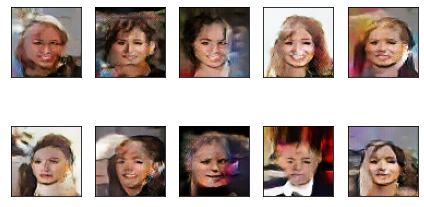

6332/6332 [==============================] - 898s 142ms/step - discriminatorLoss: 0.6495 - generatorLoss: 0.9355
Epoch 29/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6496 - generatorLoss: 0.9475

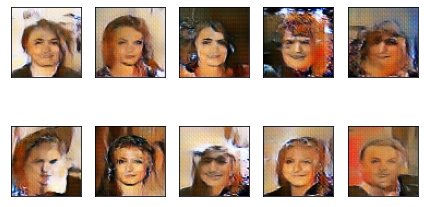

6332/6332 [==============================] - 896s 141ms/step - discriminatorLoss: 0.6496 - generatorLoss: 0.9475
Epoch 30/30
6331/6332 [============================>.] - ETA: 0s - discriminatorLoss: 0.6477 - generatorLoss: 0.9291

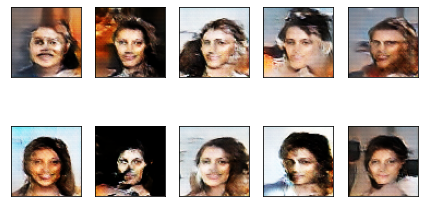

6332/6332 [==============================] - 896s 141ms/step - discriminatorLoss: 0.6477 - generatorLoss: 0.9291


In [ ]:
epochs = 30

gan = GAN(discriminator=discriminator, generator=generator)
gan.compile()

history = gan.fit(dataset_images, epochs=epochs, callbacks=[customCallback(images=10)])

[0.6204627752304077, 0.6509578227996826, 0.6569836735725403, 0.6413877010345459, 0.6217643022537231, 0.6538779735565186, 0.6624756455421448, 0.6624781489372253, 0.6637104749679565, 0.6661836504936218, 0.67276930809021, 0.6670877933502197, 0.6631256341934204, 0.6629841327667236, 0.6519007086753845, 0.6617250442504883, 0.6568577289581299, 0.6588534116744995, 0.6575801968574524, 0.6515079736709595, 0.6592188477516174, 0.6532099843025208, 0.6579139232635498, 0.653153657913208, 0.652420163154602, 0.6507151126861572, 0.6549251675605774, 0.6494521498680115, 0.6495783925056458, 0.6476951241493225]
[1.1784588098526, 1.073647379875183, 1.0325579643249512, 1.0867807865142822, 1.0945242643356323, 0.9939367175102234, 0.9604434967041016, 0.9532744288444519, 0.9400205016136169, 0.9156365990638733, 0.9221110343933105, 0.9272487163543701, 0.9277368187904358, 0.9285678267478943, 0.9355790019035339, 0.9270744919776917, 0.9337893724441528, 0.9366997480392456, 0.9329284429550171, 0.9464203715324402, 0.9283

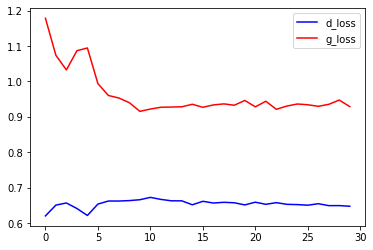

In [ ]:
# Get losses from each epoch 
discriminatorLosses = (history.history)['discriminatorLoss']
generatorLosses = (history.history)['generatorLoss']
print(discriminatorLosses)
print(generatorLosses)

plt.plot(discriminatorLosses, label='d_loss', color='blue')
plt.plot(generatorLosses, label='g_loss', color='red')
plt.legend()

In [ ]:
## Evaluating image quality w/ FID 

# define model
inception = keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87924736/87910968 [==============================] - 5s 0us/step


In [ ]:
from skimage.transform import resize
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import preprocess_input

def upscale(images, new_shape):
	result = list()
	for image in images:
		# resize 
		upscaled = resize(image, new_shape, 0)
		# store
		result.append(upscaled)
	return np.asarray(result)
 
def getFID(model, img1, img2):
  # let the DCGAN run on two images
	activation1 = model.predict(img1)
	activation2 = model.predict(img2)
 
	# calculate mean and covariance 
	mean1, cov1 = activation1.mean(axis=0), np.cov(activation1, rowvar=False)
	mean2, cov2 = activation2.mean(axis=0), np.cov(activation2, rowvar=False)
 
	# get mean squared difference 
	meanDiff = np.sum((mean1 - mean2)**2.0)
 
	# calculate sqrt of product between cov
	sigmaMean = sqrtm(cov1.dot(cov2))
 
	if np.iscomplexobj(sigmaMean):
		sigmaMean = sigmaMean.real
	# calculate score
	FID = meanDiff + np.trace(cov1 + cov2 - 2.0 * sigmaMean)
	return FID

# define collections of 10 fake images
fakeSet1 = np.zeros((10,64,64,3))
noise = tf.random.normal(shape=(10, noise_shape))
fake = gan.generator(noise)
fake *= 255
fake.numpy()
for i in range(10):
  fakeSet1[i] = fake[i]

fakeSet2 = np.zeros((10,64,64,3))
noise = tf.random.normal(shape=(10, noise_shape))
fake = gan.generator(noise)
fake *= 255
fake.numpy()
for i in range(10):
  fakeSet2[i] = fake[i]

# preprocess sets
fakeSet1 = fakeSet1.astype('float32')
fakeSet2 = fakeSet2.astype('float32')

fakeSet1 = upscale(fakeSet1, (299,299,3))
fakeSet2 = upscale(fakeSet2, (299,299,3))

fakeSet1 = preprocess_input(fakeSet1)
fakeSet2 = preprocess_input(fakeSet2)

# FID between two sets of generated images
fid = getFID(inception, fakeSet1, fakeSet2)
print('FID (generated vs generated): %.3f' % fid)


fakeSet3 = np.zeros((10,64,64,3))
# get 10 real images
counter = 0
for batch in dataset_images:
  if(counter >=9):
    break;
  rand = np.random.randint(0, 32)
  fakeSet3[counter] = batch[rand]
  counter+=1

# preprocessing
fakeSet3 = fakeSet3.astype('float32')
fakeSet3 = upscale(fakeSet3, (299,299,3))
fakeSet3 = preprocess_input(fakeSet3)

# FID between generated and real images
fid = getFID(inception, fakeSet1, fakeSet3)
print('FID (generated vs real): %.3f' % fid)

FID (generated vs generated): 176.123
FID (generated vs real): 535.813
